# Aprendizagem Automática - Assignment 1 

In [34]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Models and selection methods
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso

# Binary classifier metrics
from sklearn.metrics import precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

# Linear regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr

Importação do dataset parkinsons

In [28]:
parkinsons_data = pd.read_csv("parkinsons_updrs.data")

## Objective 1
Preparação do dataset

In [3]:
# Copiar o dataframe original
parkinsons_objective1 = parkinsons_data.copy()
# Remover a coluna total_UPDRS e subject#
parkinsons_objective1.drop(columns=["subject#","total_UPDRS"], inplace=True)

# Divisão do dataset em variaveis independentes e dependentes
X_obj1 = parkinsons_objective1[set(parkinsons_objective1.columns) - {"motor_UPDRS"}]
y_obj1 = parkinsons_objective1["motor_UPDRS"]

# Converter para np array
Xc_obj1 = X_obj1.to_numpy()
yc_obj1 = y_obj1.to_numpy()

# Divisão do dataset em training set e independent validation set
X_obj1_TRAIN, X_obj1_IVS, y_obj1_TRAIN, y_obj1_IVS = train_test_split(Xc_obj1, yc_obj1, test_size=0.10, random_state=314)

### Fitting e validação dos modelos

In [5]:
# NOTA: é preciso fazer isto para diferentes hyperparameters e guardar
#       as metricas para cada um, assim podemos comparar depois e determinar
#       qual os melhores hyperparameters antes de validar-mos o modelo com os
#       dados IVS. Depois de fazer-mos isto para o decision tree regressor, temos
#       de o fazer para o linear regressor que vamos dar na aula de amanha

##### Decision Tree Regressor

N-Cross validation

In [83]:
params = [
    {"max_depth" : [6,8,10,12,14,16,18,20,22,24,26,28,30],
    "min_samples_leaf" : [1,5,10,20],
    "min_samples_split" : [2,5,10,20]}
]


grid_search = GridSearchCV(
    DecisionTreeRegressor(), params, scoring="neg_mean_squared_error", cv=10, n_jobs=-1
)

grid_search.fit(X_obj1_TRAIN, y_obj1_TRAIN)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid=[{'max_depth': [6, 8, 10, 12, 14, 16, 18, 20, 22, 24,
                                        26, 28, 30],
                          'min_samples_leaf': [1, 5, 10, 20],
                          'min_samples_split': [2, 5, 10, 20]}],
             scoring='neg_mean_squared_error')

In [84]:
grid_search.best_params_

{'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 10}

In [85]:
grid_search.best_score_

-5.631573486324941

In [92]:
TRUTH=None
PREDS=None

for train_index, test_index in kf1.split(X_obj1_TRAIN):
    X_train, X_test = X_obj1_TRAIN[train_index], X_obj1_TRAIN[test_index]
    y_train, y_test = y_obj1_TRAIN[train_index], y_obj1_TRAIN[test_index]
    dtr_obj1 = DecisionTreeRegressor(max_depth=22, min_samples_leaf=1, min_samples_split=10)
    dtr_obj1.fit(X_train, y_train)
    preds = dtr_obj1.predict(X_test)
    if TRUTH is None:
        PREDS=preds
        TRUTH=y_test
    else:
        PREDS=np.hstack((PREDS, preds))
        TRUTH=np.hstack((TRUTH, y_test))

In [93]:
print("The RVE is: ", explained_variance_score(TRUTH, PREDS))
print("The rmse is: ", mean_squared_error(TRUTH, PREDS, squared=False))
corr, pval=pearsonr(TRUTH, PREDS)
print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))

print("The Maximum Error is is: ", max_error(TRUTH, PREDS))
print("The Mean Absolute Error is: ", mean_absolute_error(TRUTH, PREDS))

The RVE is:  0.9200029186810572
The rmse is:  2.301280878761201
The Correlation Score is is: 0.9597 (p-value=0.000000e+00)

The Maximum Error is is:  26.300400000000003
The Mean Absolute Error is:  0.7666607590931843


In [94]:
dtc_obj1_ivs = DecisionTreeRegressor(max_depth=28, min_samples_leaf=5, min_samples_split=5)
dtc_obj1_ivs.fit(X_obj1_TRAIN,y_obj1_TRAIN)
ivs_obj1_preds = dtc_obj1_ivs.predict(X_obj1_IVS)

In [95]:
print("The RVE is: ", explained_variance_score(y_obj1_IVS, ivs_obj1_preds))
print("The rmse is: ", mean_squared_error(y_obj1_IVS, ivs_obj1_preds, squared=False))
corr, pval=pearsonr(y_obj1_IVS, ivs_obj1_preds)
print("The Correlation Score is is: %6.4f (p-value=%e)\n"%(corr,pval))

print("The Maximum Error is is: ", max_error(y_obj1_IVS, ivs_obj1_preds))
print("The Mean Absolute Error is: ", mean_absolute_error(y_obj1_IVS, ivs_obj1_preds))

The RVE is:  0.8580092408886714
The rmse is:  3.0440803805845937
The Correlation Score is is: 0.9278 (p-value=4.800128e-253)

The Maximum Error is is:  19.635428571428573
The Mean Absolute Error is:  1.090232550750459


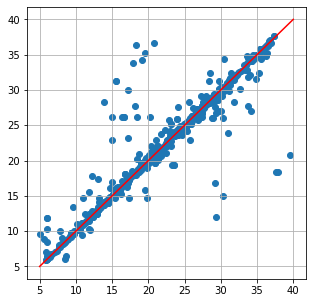

In [96]:
plt.figure(figsize=(5,5))
plt.scatter(y_obj1_IVS, ivs_obj1_preds)
plt.plot((5, 40), (5,40), c="r")
plt.grid()
plt.show()

Linear regressor

In [77]:
params_linear = [
    {"alpha" : [x*0.001 for x in range(1,100)],
    "normalize" : [True, False]}
]

grid_search2 = GridSearchCV(
    Lasso(), params_linear, scoring="neg_mean_squared_error", cv=10, n_jobs=-1
)

grid_search2.fit(X_obj1_TRAIN, y_obj1_TRAIN)

GridSearchCV(cv=10, estimator=Lasso(), n_jobs=-1,
             param_grid=[{'alpha': [0.001, 0.002, 0.003, 0.004, 0.005, 0.006,
                                    0.007, 0.008, 0.009000000000000001, 0.01,
                                    0.011, 0.012, 0.013000000000000001, 0.014,
                                    0.015, 0.016, 0.017, 0.018000000000000002,
                                    0.019, 0.02, 0.021, 0.022, 0.023, 0.024,
                                    0.025, 0.026000000000000002, 0.027, 0.028,
                                    0.029, 0.03, ...],
                          'normalize': [True, False]}],
             scoring='neg_mean_squared_error')

In [78]:
grid_search2.best_params_

{'alpha': 0.001, 'normalize': True}

In [80]:
grid_search2.best_score_

-56.272519542686304

## Objective 2
Preparação do dataset

In [31]:
# Copiar o dataframe original
parkinsons_objective2 = parkinsons_data.copy()
# Remover a coluna subject# e motor_UPDRS
parkinsons_objective2.drop(columns=["subject#","motor_UPDRS"], inplace=True)
# Transformação de total_UPDRS em variavel binaria
parkinsons_objective2["total_UPDRS"] = parkinsons_objective2["total_UPDRS"].apply(lambda x : "positive" if x > 40 else "negative")

X_obj2 = parkinsons_objective2[set(parkinsons_objective2.columns) - {"total_UPDRS"}]
y_obj2 = parkinsons_objective2["total_UPDRS"]

# Converter para np array
Xc_obj2 = X_obj2.to_numpy()
yc_obj2 = y_obj2.to_numpy()